In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check data shape
for images, _ in train_loader:
    print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
    break

Batch shape: torch.Size([32, 1, 28, 28])


In [3]:
class RBM(torch.nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, lr=0.01):
        super(RBM, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(visible_dim, hidden_dim) * 0.01)
        self.a = torch.nn.Parameter(torch.zeros(visible_dim))  # Visible bias
        self.b = torch.nn.Parameter(torch.zeros(hidden_dim))   # Hidden bias
        self.lr = lr

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def sample_hidden(self, v):
        h_probs = self.sigmoid(torch.matmul(v, self.W) + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = self.sigmoid(torch.matmul(h, self.W.t()) + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def contrastive_divergence(self, v0, k=1):
        # Positive phase
        h0_probs, h0_sample = self.sample_hidden(v0)

        # Negative phase (k-step Gibbs sampling)
        vk = v0.clone()
        for _ in range(k):
            _, hk_sample = self.sample_hidden(vk)
            vk_probs, vk_sample = self.sample_visible(hk_sample)
            vk = vk_sample

        # Update parameters
        positive_association = torch.matmul(v0.t(), h0_probs)
        negative_association = torch.matmul(vk.t(), self.sigmoid(torch.matmul(vk, self.W) + self.b))

        self.W.data += self.lr * (positive_association - negative_association) / v0.size(0)
        self.a.data += self.lr * (v0.mean(dim=0) - vk.mean(dim=0))
        self.b.data += self.lr * (h0_probs.mean(dim=0) - self.sigmoid(torch.matmul(vk, self.W) + self.b).mean(dim=0))

In [4]:
# Initialize RBM
visible_dim = 784  # 28x28 images
hidden_dim = 128
rbm = RBM(visible_dim, hidden_dim, lr=0.01)

# Training parameters
epochs = 20

In [5]:
import torch
import matplotlib.pyplot as plt
import os
import math

def sample_from_rbm(rbm, epoch, out_folder="train_tmp", n_samples=16, gibbs_steps=100):
    """
    Generates n_samples from the RBM using gibbs_steps of alternating Gibbs sampling,
    then saves them as a grid in out_folder/fantasies_step_{epoch}.png.
    Returns the output file path.
    """

    os.makedirs(out_folder, exist_ok=True)

    visible_dim = rbm.W.shape[0]  # assuming [visible_dim, hidden_dim] = [784, 128]

    # 1) Initialize visible states randomly (Bernoulli)
    #    or you can start them as all zeros, or sample from real data, etc.
    v = (torch.rand(n_samples, visible_dim) > 0.5).float()

    # 2) Run Gibbs sampling for gibbs_steps
    with torch.no_grad():
        for _ in range(gibbs_steps):
            # sample hidden
            h_probs, h_samples = rbm.sample_hidden(v)
            # sample visible
            v_probs, v_samples = rbm.sample_visible(h_samples)
            # update v
            v = v_samples

    # 3) Plot the final v as images
    sqrt_n = int(math.sqrt(n_samples))
    fig, axes = plt.subplots(sqrt_n, sqrt_n, figsize=(8, 8))

    for i in range(n_samples):
        row = i // sqrt_n
        col = i % sqrt_n
        ax = axes[row, col]

        # Reshape each sample into 28x28
        img = v[i].view(28, 28).cpu()
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")

    plt.suptitle(f"RBM Fantasies at Epoch {epoch}", fontsize=14)
    plt.tight_layout()

    out_path = os.path.join(out_folder, f"fantasies_step_{epoch}.png")
    plt.savefig(out_path, dpi=100)
    plt.close(fig)
    return out_path

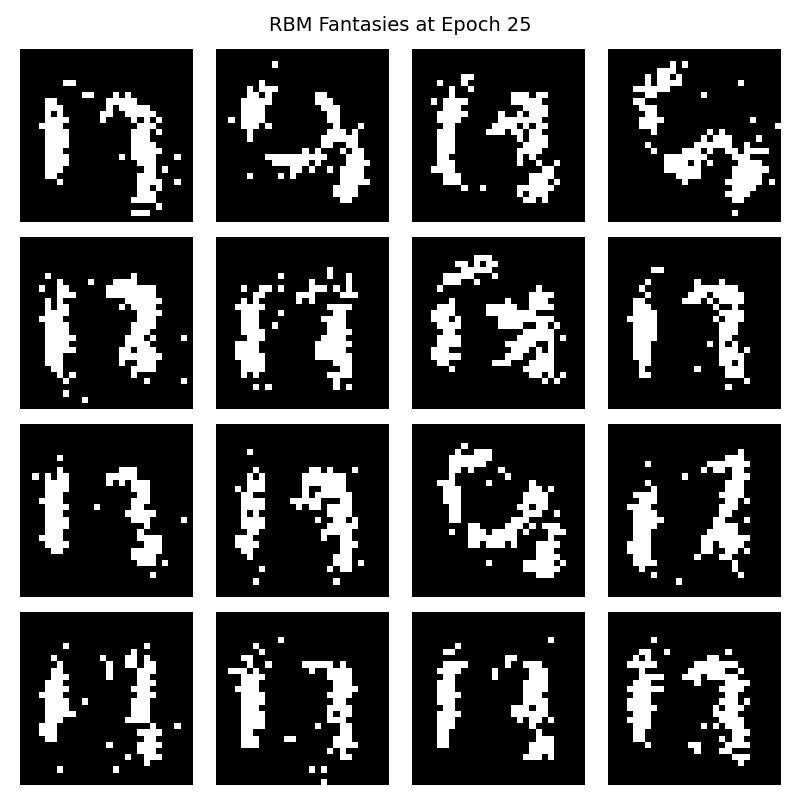

KeyboardInterrupt: 

In [7]:
from IPython.display import clear_output, Image as IPyImage
import os

def train_rbm_with_fantasies(rbm, train_loader, epochs=10, out_folder="train_tmp"):
    visible_dim = 784  # for MNIST

    for epoch in range(epochs):
        epoch_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, visible_dim)
            data = (data > 0.5).float()  # Binarize

            # 1) Contrastive Divergence step
            rbm.contrastive_divergence(data)

            # 2) Compute reconstruction error as a metric
            h_probs, h_samples = rbm.sample_hidden(data)
            v_probs, v_samples = rbm.sample_visible(h_samples)
            loss = torch.mean((data - v_probs) ** 2)
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)

        # --- Visualize progress in the notebook ---
        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

        # (Optional) Save weights
        # weights_path = save_rbm_weights(rbm, epoch+1, out_folder=out_folder, num_filters=16)

        # 3) Generate fantasies to see generative ability
        fantasies_path = sample_from_rbm(rbm, epoch+1, out_folder=out_folder,
                                         n_samples=16, gibbs_steps=100)

        # Display the fantasies inline in Jupyter
        display(IPyImage(filename=fantasies_path))

    print("Training complete. Fantasies generated each epoch.")

# Train the RBM
train_rbm_with_fantasies(rbm, train_loader, epochs=50)

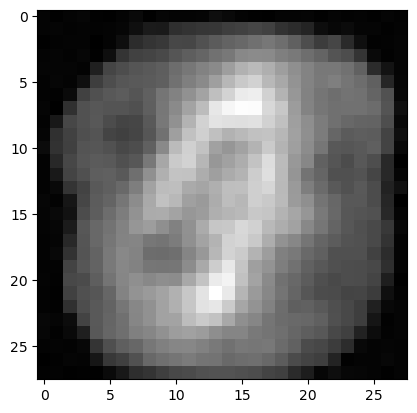

In [8]:
weights = rbm.W.data.cpu()
weights = weights.sum(dim=1)
plt.imshow(weights.view(28, 28), cmap='gray')
plt.show()

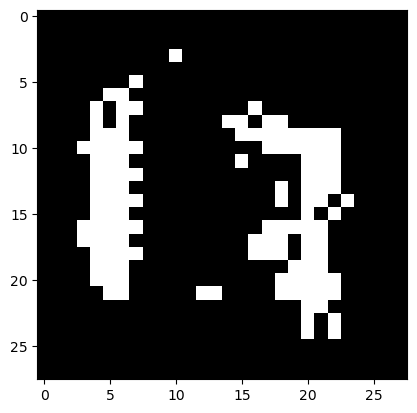

In [11]:
# sampling from random noise:

def generate_samples(model, num_samples=10, gibbs_steps=1000):
    # Disable gradient tracking
    with torch.no_grad():
        # Start with random visible units
        v = torch.bernoulli(torch.rand(num_samples, 784)).float()

        # Run Gibbs sampling
        for _ in range(gibbs_steps):
            _, h = model.sample_hidden(v)
            _, v = model.sample_visible(h)

        # Detach and convert to NumPy
        return v.detach().cpu().numpy()

# Usage with proper visualization
samples = generate_samples(rbm)
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.show()

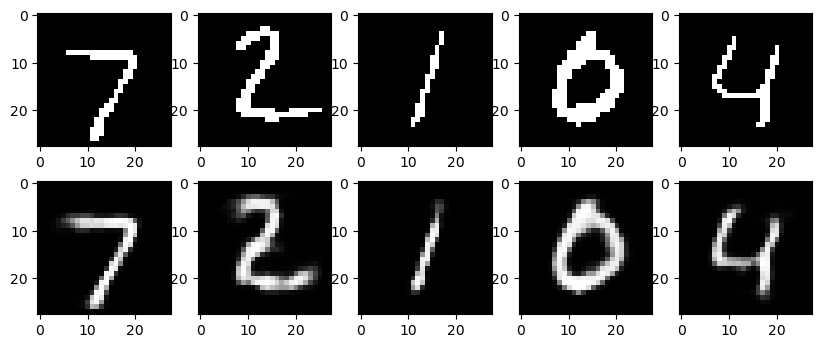

In [12]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, data_loader, num=5):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.view(-1, visible_dim)
            images = (images > 0.5).float()  # Binarize

            # Reconstruct
            h_probs, _ = model.sample_hidden(images)
            v_probs, _ = model.sample_visible(h_probs)

            # Plot
            plt.figure(figsize=(10, 4))
            for i in range(num):
                # Original
                ax = plt.subplot(2, num, i+1)
                plt.imshow(images[i].reshape(28, 28), cmap='gray')

                # Reconstructed
                ax = plt.subplot(2, num, num+i+1)
                plt.imshow(v_probs[i].reshape(28, 28), cmap='gray')
            plt.show()
            break

plot_reconstructions(rbm, test_loader)

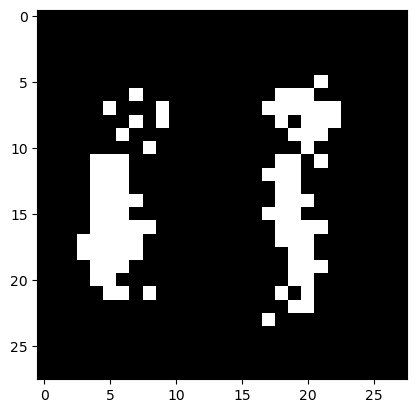

In [13]:
# sampling from random noise:

def generate_samples(model, num_samples=10, gibbs_steps=1000):
    # Disable gradient tracking
    with torch.no_grad():
        # Start with random visible units
        v = torch.bernoulli(torch.rand(num_samples, 784)).float()

        # Run Gibbs sampling
        for _ in range(gibbs_steps):
            _, h = model.sample_hidden(v)
            _, v = model.sample_visible(h)

        # Detach and convert to NumPy
        return v.detach().cpu().numpy()

# Usage with proper visualization
samples = generate_samples(rbm)
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.show()